In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(r"C:\Users\R.R. Dharun raagav\Desktop\Shanmuga priya projects Ml project\FAOSTAT_data.csv")
df.head(5)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


In [3]:
df.isnull().sum()

Domain Code              0
Domain                   0
Area Code (M49)          0
Area                     0
Element Code             0
Element                  0
Item Code (CPC)          5
Item                     0
Year Code                0
Year                     0
Unit                     2
Value                 6517
Flag                     4
Flag Description        13
Note                219549
dtype: int64

In [4]:
df = df.drop("Note" , axis=1)

In [5]:
unit_mapping = {
    "Area harvested":"ha",
    "Yield":"kg/ha",
    "Production":"t"
}
df["Unit"] = df["Unit"].fillna(df["Element"].map(unit_mapping))

In [6]:
df["Item Code (CPC)"] = df["Item Code (CPC)"].ffill()
print(df["Item Code (CPC)"].isnull().sum())

0


In [7]:
df["Flag"] = df["Flag"].ffill()
print(df["Flag"].isnull().sum())

0


In [8]:
unique_flags = df[["Flag", "Flag Description"]].drop_duplicates()
flag_mapping = df[["Flag", "Flag Description"]].dropna().drop_duplicates().set_index("Flag")["Flag Description"].to_dict()

print(flag_mapping)

{'A': 'Official figure', 'E': 'Estimated value', 'I': 'Imputed value', 'X': 'Figure from international organizations', 'M': 'Missing value (data cannot exist, not applicable)'}


In [9]:
df["Flag Description"] = df["Flag Description"].fillna(df["Flag"].map(flag_mapping))
print(df["Flag Description"].isnull().sum())

0


In [10]:
df["Value"] = df.groupby(["Area", "Item", "Year"])["Value"].transform(
    lambda x: x.fillna(x.median()) if not x.isnull().all() else x
)

In [11]:
# Convert Value column to numeric (ensure it's not object type)
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

# Step 1: Fill missing values using group-wise median
df["Value"] = df.groupby(["Area", "Item", "Year"])["Value"].transform(
    lambda x: x.fillna(x.median()) if not x.isnull().all() else np.nan
)

# Step 2: Fill remaining NaNs using the median of that Item across all areas and years
df["Value"] = df.groupby(["Item"])["Value"].transform(lambda x: x.fillna(x.median()))

# Step 3: Fill remaining NaNs with overall median
df["Value"] = df["Value"].fillna(df["Value"].median())


# Final check: Print the number of remaining NaNs
print(f"Remaining missing values: {df['Value'].isnull().sum()}")

Remaining missing values: 0


In [12]:
# 1. Pivot the table to create columns from unique 'Element' values
df_pivot = df.pivot_table(
    index=["Year", "Area", "Item"],
    columns="Element",
    values="Value",
    aggfunc="sum"
).reset_index()

# 2. Drop rows that have NaN in critical columns (like Area harvested, Production, Yield)
important_columns = ["Area harvested", "Production", "Yield"]  # you can add more if needed

df_pivot = df_pivot.dropna(subset=important_columns)


In [13]:
df_pivot = df_pivot.drop(columns=["Laying", "Milk Animals", "Producing Animals/Slaughtered", "Stocks", "Yield/Carcass Weight"])


In [14]:

# 3. Optional: Save the cleaned pivoted data
df_pivot.to_csv("Cleaned_Pivoted_Data.csv", index=False)
print("✅ Cleaned pivoted data saved as 'Cleaned_Pivoted_Data.csv'")

✅ Cleaned pivoted data saved as 'Cleaned_Pivoted_Data.csv'


In [15]:
df_pivot.head(3)

Element,Year,Area,Item,Area harvested,Production,Yield
0,2019,Afghanistan,"Almonds, in shell",29203.0,38205.00,1308.3
1,2019,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",25293.0,17807.76,704.1
2,2019,Afghanistan,Apples,27559.0,250324.00,9083.2


In [16]:
df_pivot.isnull().sum()

Element
Year              0
Area              0
Item              0
Area harvested    0
Production        0
Yield             0
dtype: int64

In [17]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load your full dataset before encoding
df_full = pd.read_csv(r"C:\Users\R.R. Dharun raagav\Desktop\Shanmuga priya projects Ml project\Cleaned_Pivoted_Data.csv")  # original raw format

# Fix duplicate columns (important!)
df_full = df_full.loc[:, ~df_full.columns.duplicated()]

# Optional: ensure "Year" column exists and is numeric
df_full["Year"] = pd.to_numeric(df_full["Year"], errors='coerce')

# Split dataset: train until 2023
train_df = df_full[df_full["Year"] <= 2023]

# One-hot encode categorical columns
df_encoded = pd.get_dummies(train_df, columns=["Area", "Item", "Year"])

# Separate features and label
X = df_encoded.drop("Production", axis=1)
y = df_encoded["Production"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model
with open("crop_production_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save encoded column list for Streamlit app
with open("final_encoded_dataset.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)


In [18]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)


print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.8901659853905226
MSE: 26292439971558.484


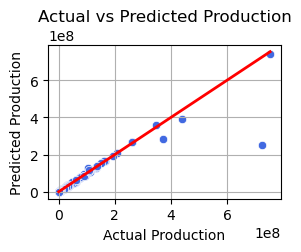

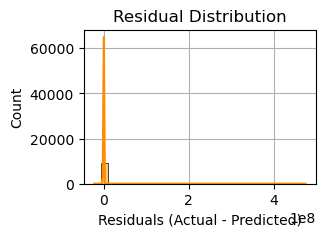

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict using the trained model
y_pred = model.predict(X_test)

# 1️⃣ Actual vs Predicted Plot
plt.figure(figsize=(3, 2))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Actual vs Predicted Production")
plt.grid(True)
plt.show()

# 2️⃣ Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(3, 2))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residual Distribution")
plt.grid(True)
plt.show()
